In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yaml
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
import sys
sys.path.append("..")
from uvsw_part import simulation
import copy
from math import e
import math
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor

In [2]:
LIST_PATH_1 = "../data/params/List1.txt"
LIST_PATH_2 = "../data/params/List2.txt"

In [3]:
def t_couverture (ref,dfy):
    """
    Fonction permettant de calculer le pourcentage de valeurs du modèle simplifié compris à l'intérieur du modèle de réference
    
    Arguments :
        ref (pandas.core.series.Series)        : Modèle de reférence
        dfy (numpy.ndarray)                    : Modèle simplifié genéré par le simulateur
        
    Sortie :
        Taux de couverture des données (float) : Pourcentage de valeurs de la simulation 
        à l'intérieur de la réference   
    """
    same_sign = 0 # Nombres de même signe dans reference et simulation (pris 1 par 1)
    diff_sign = 0 # Nombres de signes différents dans reference et simulation (pris 1 par 1)
    couverture = 0 # Nombres de même signe ET avec la ref qui couvre la simulation
    
    ref_taille = len(ref) # Nombre total de valeurs dans ref et sim
    
    
    for i in range(0,ref_taille):
        if(np.sign(ref[i]) == np.sign(dfy[i])): #Si la reference et la sim sont du même signe
            same_sign = same_sign + 1


            if(ref[i] < 0): # Quand la reference < 0
                if(ref[i] - dfy[i] < 0):
                    couverture = couverture + 1
                

            if(ref[i] > 0): # Quand la reference > 0
                if(ref[i] - dfy[i] > 0):
                    couverture = couverture + 1

            if(ref[i] == 0): # Quand la reference = 0
                if(ref[i] - dfy[i] == 0):
                    couverture = couverture + 1

            if(math.isnan(ref[i]) and math.isnan(dfy[i]) == True): # Quand la reference = NaN
                couverture = couverture + 1             
            
        else :
            diff_sign = diff_sign + 1 # Si ce n'est pas le même signe
            

    taux_couverture = (couverture / ref_taille) * 100 # Calcul du taux en pourcentage
            
    print("Nombres de valeurs au total = " + str(ref_taille))
    print("Nombres de valeurs dans sim et ref avec le même signe = " + str(same_sign))
    print("Nombres de valeurs avec sim et ref avec signes differents = " + str(diff_sign))
    print("----------------------------------")
    print("Total des 2 par rapport à la reference = " + str(same_sign + diff_sign) + " / " + str(ref_taille))
    print("Nombres de valeurs dans sim et ref avec le même signe ET couverts = " + str(couverture) + " / " + str(same_sign))
 
    print("----------------------------------")
    
    
    print("Pourcentage de couverture : " + str(taux_couverture) + "%")
    return taux_couverture


In [7]:
def generate_ts(u,h,tension,clo,LIST_PATH,TS_INDEX) :
    
    """
    Fonction utilisant les paramètres de u,h,tension,cl0 pour génerer une Time-Series de simulation.
    Comparaison du modèle de simulation ave le modèle de réference chargé avec le fichier Liste souhaité et l'index de la Time-Series
    
    Arguments : 
        u (float)          : Paramètre
        h (float)          : Paramètre
        tension (float)    : Paramètre
        cl0 (float)        : Paramètre
        LIST_PATH (string) : Chemin vers le fichier Liste
        TS_INDEX (int)     : Index de la Time-Series à charger (commence à 0) 
    
    Sortie : 
        Visualisation graphique du modèle simplifié et du modèle de réference avec Matplotlib
        Visualisation graĥique du modèle simplifié et du modèle de réference Plotly
    
    """

    #Chargement du fichier List*.txt avec le chemin
    data_list = pd.read_csv(LIST_PATH, delim_whitespace=True)
    
    #Chargement des paramètres de base d'une Time-Series pour la simulation avec son index (Index commence à 0)
    set_params = data_list.iloc[TS_INDEX,:]

    #Chargement des Time-Series de réference selon le fichier Liste utilisé
    list_number = LIST_PATH[-9:]

    if(list_number == "List1.txt"):
        ref = pd.read_csv("../data/ref/list1/graph{}.csv".format(set_params["nc"]))
        print("Chargement du fichier Liste : Liste_1")
    if(list_number == "List2.txt"):
        ref = pd.read_csv("../data/ref/list2/graph{}.csv".format(set_params["nc"]))
        print("Chargement du fichier Liste : Liste_2")
    if(list_number !=  "List1.txt" and list_number != "List2.txt" ):
        print("Erreur, Numéro de liste non supporté")
    
    
    
    
    #Chargement du fichier YAML contenant la liste des paramètres
    cfg = yaml.safe_load(open('../data/config/example.in.yaml', 'r'))

    #Chargement des paramètres à tester 
    cfg["cable"]["h"] = float(h)
    cfg["cable"]["tension"] = float(tension)
    cfg["wakeosc"]["u"] = float(u)
    cfg["wakeosc"]["cl0"]= float(clo)

    #Setup des paramètres permettant de produire un modèle simplifié de même longueur que le modèle de réference
    cfg["simulation"]["tf"] = float(set_params["tf[s]"])
    cfg["simulation"]["dt"] = cfg["simulation"]["tf"] / len(ref) 
    cfg["simulation"]["dr"] = cfg["simulation"]["tf"] / len(ref) 



    print("h Value: ", cfg["cable"]["h"], " u Value: ", cfg["wakeosc"]["u"]," tension Value: ",cfg["cable"]["tension"])
    print("tf Value ", cfg["simulation"]["tf"])
    
    # Lancement du simulateur
    dfy, _ = simulation.run_cable_wakeosc(cfg)
    
    #Calcul des métriques
    mse = mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    rmse = mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1],squared = False)
    mea = mean_absolute_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    r2 = r2_score(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    taux_couverture = t_couverture(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    
    
    #Stockage des métriques sous format texte en vue de la visualisation
    mse_text= "MSE = %s " % mse
    rmse_text = "RMSE = %s " % rmse
    mea_text = "MEA = %s " % mea
    r2_text = "R2 = %s " % r2
    taux_couverture_text = "Taux de couverture = %s %%" % taux_couverture


    #Visualisation avec Matplotlib
    plt.figure(figsize = (20,8))
    plt.plot(ref['time'], ref['y/d'], label = "Signal de reference")
    plt.plot(dfy.index, dfy['s=0.250']/0.025, label = "Signal du simulateur")
    plt.xlabel('time (s)',fontsize=18)
    plt.ylabel('y/d',fontsize=18)

    #Affichage des métriques dans la visualisation
    plt.figtext(0.5, 0.00, mse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.05, rmse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.10, mea_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.15, r2_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    
    plt.figtext(0.5, -0.25, "h = '{0}', tension = '{1}', u = '{2}', clo = '{3}', eps = '{4}'".format(cfg['cable']['h'],cfg['cable']['tension'],cfg['wakeosc']['u'],cfg["wakeosc"]["cl0"],cfg["wakeosc"]["eps"]), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.30, taux_couverture_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    title = "Comparaison du signal de simulation avec le signal de reference"
    plt.title(title,fontsize=18)

    plt.legend()
    plt.show() 

    
    # Visualisation avec Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ref['time'], y=ref['y/d'],
                    name='Signal de reference'))
    fig.add_trace(go.Scatter(x=dfy.index, y=dfy['s=0.250']/0.025,
                    name='Signal de simulation'))
    
    fig.update_layout(
        title="Comparaison du signal de simulation avec le signal de reference",
        xaxis_title="Timesteps",
        yaxis_title="Signal",
        legend_title="Signaux",
    )

    fig.show()
    ref_sortie = ref['y/d']
    sim_sortie = (dfy['s=0.250']/0.025).values[:-1]
    
    return ref_sortie,sim_sortie

In [8]:
ref_TS_1_List_1, sim_TS_1_List_1 = generate_ts(u = 0.9581605926701262,h = 350.3177587546673,
                       tension = 19283.282924451374,clo = 0.005546471167606932,
                      LIST_PATH  = LIST_PATH_1,TS_INDEX = 0)

Chargement du fichier Liste : Liste_1
h Value:  350.3177587546673  u Value:  0.9581605926701262  tension Value:  19283.282924451374
tf Value  7.206
 -- running 44.46%

KeyboardInterrupt: 

In [ ]:
ref_TS_6_List_1, sim_TS_6_List_1 = generate_ts(u = 0.9535838147886668,h = 309.49288554663354,
                       tension = 11605.8732786244,clo = 0.6,
                      LIST_PATH  = LIST_PATH_1,TS_INDEX = 5)

In [ ]:
ref_TS_1_List_2,sim_TS_1_List_2 = generate_ts(u = 2.15,h = 100,
                       tension = 32100,clo = 0.60,
                      LIST_PATH  = LIST_PATH_2,TS_INDEX = 0)

In [ ]:
ref_TS_2_List_2, sim_TS_2_List_2 = generate_ts(u = 2.15,h = 100,
                       tension = 32200,clo = 3.0,
                      LIST_PATH  = LIST_PATH_2,TS_INDEX = 1)

In [ ]:
new_sim1 = pd.DataFrame({'list': 1, 'n_ts': 1, 'ref': ref_TS_1_List_1,'sim':sim_TS_1_List_1 })
new_sim2 = pd.DataFrame({'list': 1, 'n_ts': 6, 'ref': ref_TS_6_List_1,'sim':sim_TS_6_List_1 })
new_sim3 = pd.DataFrame({'list': 2, 'n_ts': 1, 'ref': ref_TS_1_List_2,'sim':sim_TS_1_List_2 })
new_sim4 = pd.DataFrame({'list': 2, 'n_ts': 2, 'ref': ref_TS_2_List_2,'sim':sim_TS_2_List_2 })

In [ ]:
#simulations = pd.DataFrame()

In [ ]:
simulations = pd.concat([new_sim1,new_sim2,new_sim3,new_sim4],axis = 0)

In [ ]:
simulations

In [ ]:
plt.figure(figsize = (30,12))
plt.plot(simulations.ref.values)
plt.plot(simulations.sim.values)

In [ ]:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=simulations.ref.index, y=simulations.ref.values,
                    name='Signal de reference'))
    fig.add_trace(go.Scatter(x=simulations.sim.index, y=simulations.sim.values,
                    name='Signal de simulation'))
    
    fig.update_layout(
        title="Comparaison du signal de simulation avec le signal de reference",
        xaxis_title="Timesteps",
        yaxis_title="Signal",
        legend_title="Signaux",
    )

    fig.show()

In [ ]:
simulations.to_csv('Sim_ref_4_TS_Concat.csv',header = True, index = None)

In [9]:
simulations = pd.read_csv('Sim_ref_4_TS_Concat.csv')

In [10]:
train_data = simulations[:int(simulations.shape[0]* 0.8)]
test_data = simulations[int(simulations.shape[0] * 0.8):]

In [11]:
X_train = train_data.sim.values
X_test = test_data.sim.values


In [12]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

In [13]:
y_train = train_data.ref.values
y_test = test_data.ref.values

In [14]:
random_forest = RandomForestRegressor(max_depth = 4)
random_forest.fit(X_train,y_train)

RandomForestRegressor(max_depth=4)

In [15]:
y_pred = random_forest.predict(X_test)

In [16]:
mse = mean_squared_error(y_test,y_pred)
mse

0.000239884095345397

In [17]:
r2 = r2_score(y_test,y_pred)
r2

-3.3293420985236466e-05

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(y = y_test,
                name='Reference model signal'))
fig.add_trace(go.Scatter(y = y_pred,
                name='Prediction signal'))

fig.update_layout(
    title="Comparison between reference model and prediction of a Random Forest each with 4 Time-Series combined",
    xaxis_title="Timesteps",
    yaxis_title="Signal",
    legend_title="Signals",       
)


fig.show()

fig.write_html("../outputs/visualisation/Concat_4_TS_full_values.html")

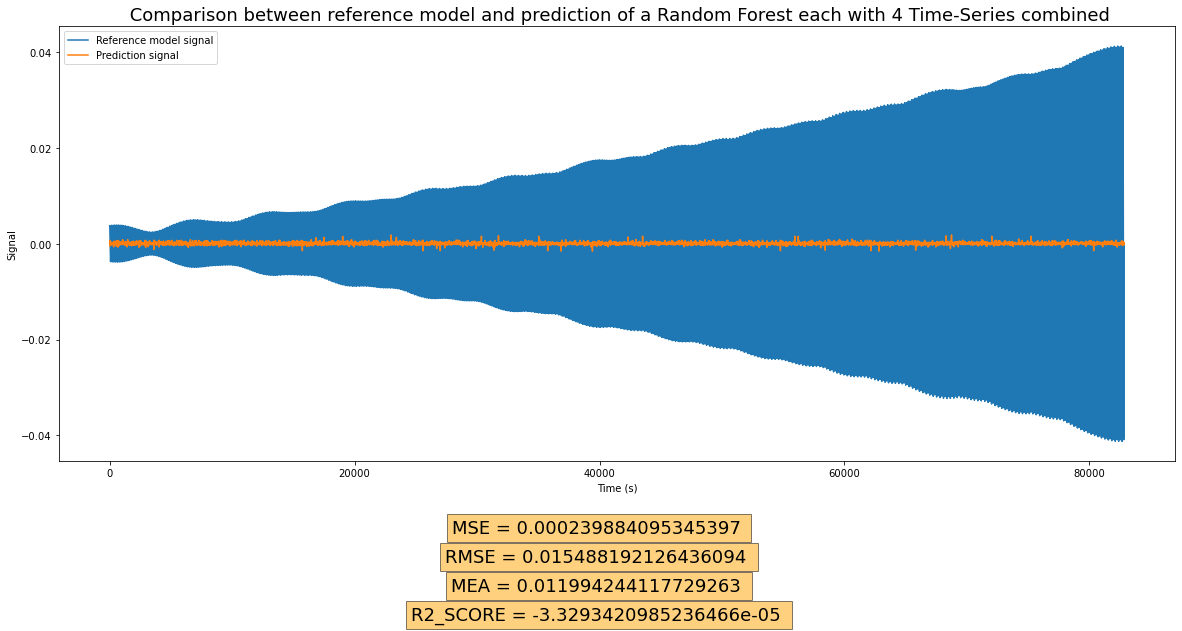

In [19]:
plt.figure(figsize = (20,8))
plt.plot(y_test, label = "Reference model signal")
plt.plot(y_pred, label = "Prediction signal")

rmse = mean_squared_error(y_pred,y_test,squared = False)
mea = mean_absolute_error(y_pred,y_test)
mse = mean_squared_error(y_pred,y_test,squared = True)
r2 = r2_score(y_test,y_pred)

mse_text = "MSE = %s " % mse
rmse_text = "RMSE = %s " % rmse
mea_text = "MEA = %s " % mea
r2_text = "R2_SCORE = %s " % r2

"""
plt.annotate(mse, xy=(0.05, 0.85), xycoords='axes fraction')
plt.annotate(rmse, xy=(0.05, 0.80), xycoords='axes fraction')
plt.annotate(mea, xy=(0.05, 0.75), xycoords='axes fraction')
plt.annotate(p_reussite_precis, xy=(0.02, 0.70), xycoords='axes fraction')
plt.annotate(p_reussite_approx, xy=(0.02, 0.65), xycoords='axes fraction')
"""
plt.figtext(0.5, 0.00, mse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.figtext(0.5, -0.05, rmse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.figtext(0.5, -0.10, mea_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.figtext(0.5, -0.15, r2_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})


#plt.figtext(0.5, -0.20, "h = '{0}', tension = '{1}', u = '{2}', clo = '{3}', eps = '{4}'".format(h,tension,u,clo,eps), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})



title = " Comparison between reference model and prediction of a Random Forest each with 4 Time-Series combined"
plt.title(title,fontsize = 18)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.legend()
plt.show()
